# 고양이 수염 스티커 만들기

## 1. 스티커 구하기 or 만들기
* 교장 사인을 사용하자

### 1-1. 사진 준비하기

In [1]:
# import library
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

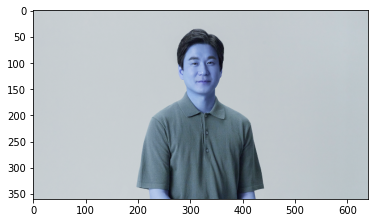

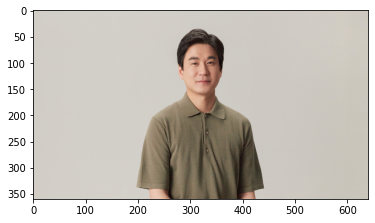

In [2]:
# 이미지 열기 & 확인
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/img11.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# 색 보정처리
# plt.imshow 이전에 RGB 이미지로 바꿔야 함!!. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 & 랜드마크 검출 하기

### 2-1. 얼굴 검출

In [3]:
# dlib을 활용!
import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

# dlib은 rgb 이미지를 입력으로 받는다고 한다.
# 이미지 변환 안 해줬으면 해줘야 함! cvtColor을 이용, opencv의 bgr -> rgb
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector를 이용해서 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #(image, num of img pyramid)

rectangles[[(287, 80) (361, 155)]]


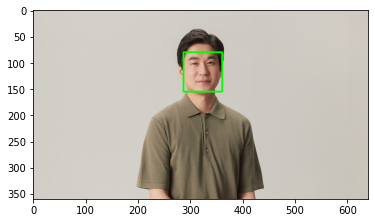

In [4]:
# 찾은 얼굴을 화면에 출력

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2-2. 랜드마크 검출

In [5]:
# 저장한 landmark 모델을 불러오자
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [6]:
# landmark_predictor는 RGB이미지와 dlib.rectangle을 입력 -> dlib.full_object_detection을 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) #RGB 이미지, rectangle (bounding box) 입력
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# points는 ```dlib.full_object_detection```의 객체. ```part()```함수로 개별 위치에 접근가능!
# 조금 더 직관적인x,y형태로 접근할 수 있도록 변환했다고 한다
# 그래서 여기서 list_points는 tuple (x,y) 68개로 이루어진 리스트가 됨!
# 이미지에서 찾아진 얼굴 개수마다 반복하면 ```list_landmark```에 68개의 랜드마크가 얼굴 개수만큼 저장됨

68


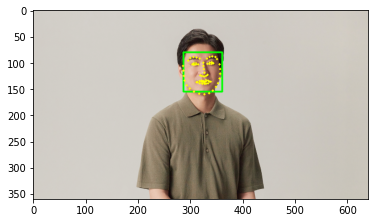

In [7]:
# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용 위치 확인하기

In [8]:
# 좌표를 확인해보자
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(327, 119)
(x,y) : (327,82)
(w,h) : (75,75)


In [9]:
# 준비해 둔 스티커 이미지를 읽어서 적용해보자
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/img111.PNG'
img_sticker = cv2.imread(sticker_path) # 이미지 읽기
img_sticker = cv2.resize(img_sticker, (w,h)) # rezise 해주기
print (img_sticker.shape)

(75, 75, 3)


In [10]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서, x,y좌표를 조정
# 이미지 시작점은 top-left 좌표이기 때문

refined_x = x - w // 2 # left
refined_y = 100  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (290,100)


In [11]:
# IF y축 좌표의 값이 음수로 계산? 이미지가 범위 밖으로 벗어나갔다는 뜻
img_sticker = img_sticker[-refined_y:] # -y 크기만큼 스티커를 crop
print (img_sticker.shape)

(75, 75, 3)


In [12]:
#top의 y 좌표는 원본 이미지의 경계 값으로 수정
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (290,0)


## 4. 스티커 적용하기

In [13]:
# 원본 이미지에 스티커를 적용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# sticker_area: 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 예제에서는 (566,0)부터 (566+268, 0+157) 범위의 이미지를 의미
# 스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용!
# 따라서 np.where를 통해 image_sticker가 0인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_stcker를 사용.
# img_show에 다시 적용

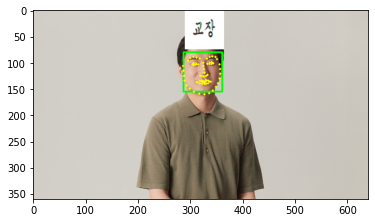

In [14]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

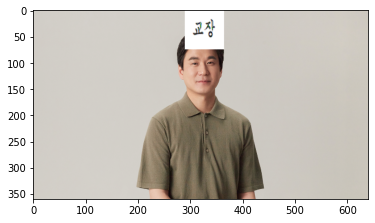

In [15]:
# bounding box와 landmark 제거하고 최종 결과 출력
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 문제점 찾아보기
* 얼굴 검출: 이렇게 정면을 보는 사진이 아닌 다른 사진은 애초에 얼굴을 인식하는게 힘들어서, bounding box가 그려지지 않았다. 머신이 좀 더 학습을 한다면 해결할 수 있을 것 같다.
* 랜드마크 검출: 교장 사인이 이마 정중앙에 위치하는 것을 기준으로 했을 때, 지금처럼 사진이 정면이 아니라 조금만 움직여도, 혹은 사진이 빛을 다른 각도에서 받거나 등의 문제가 생길 수 있다. 그런 경우 컴퓨터는 각 픽셀의 색을 다르게 인식하기 때문에, 얼굴 랜드마크를 찾기 어려울 수 있다.